In [107]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, MetaPath2Vec, Node2Vec, HANConv
from torch_geometric.data import Data
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.loader import DataLoader
import signal
import psutil


In [108]:

import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec/engine')
from core_rec import GraphTransformer, train_model, predict

import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec/engine/torch_nn')
from torch_nn import *

# # Load your data
# labels_df = pd.read_csv('labelele.csv')
# labels = labels_df['Names'].tolist()
# label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load adjacency matrix
adj_matrix = pd.read_csv('data_mother/500label.csv', header=None).values
# adj_matrix=np.loadtxt('data_mother/wgtlabel.csv', delimiter=',')


In [109]:

# Create edge index for PyTorch Geometric
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# Create node features (for simplicity, using identity matrix)
num_nodes = adj_matrix.shape[0]
x = torch.eye(num_nodes, dtype=torch.float)

# Create labels (for simplicity, using node indices as labels)
y = torch.tensor(range(num_nodes), dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)


In [133]:

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 16)
        self.conv2 = GCNConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


import torch.nn.functional as F
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_nodes, 16)
        self.conv2 = SAGEConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define TransE model
class TransE(torch.nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embedding = torch.nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = torch.nn.Embedding(num_relations, embedding_dim)
        self.embedding_dim = embedding_dim
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.entity_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.relation_embedding.weight.data)

    def forward(self, head, relation, tail):
        head_emb = self.entity_embedding(head)
        relation_emb = self.relation_embedding(relation)
        tail_emb = self.entity_embedding(tail)
        score = torch.norm(head_emb + relation_emb - tail_emb, p=1, dim=1)
        return score

# Define TransR model
class TransR(torch.nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransR, self).__init__()
        self.entity_embedding = torch.nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = torch.nn.Embedding(num_relations, embedding_dim)
        self.projection_matrix = torch.nn.Parameter(torch.Tensor(num_relations, embedding_dim, embedding_dim))
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.entity_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.relation_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.projection_matrix.data)

    def forward(self, head, relation, tail):
        head_emb = self.entity_embedding(head)
        relation_emb = self.relation_embedding(relation)
        tail_emb = self.entity_embedding(tail)
        proj_matrix = self.projection_matrix[relation]
        head_proj = torch.bmm(proj_matrix, head_emb.unsqueeze(2)).squeeze(2)
        tail_proj = torch.bmm(proj_matrix, tail_emb.unsqueeze(2)).squeeze(2)
        score = torch.norm(head_proj + relation_emb - tail_proj, p=1, dim=1)
        return score

# Define DistMult model
class DistMult(torch.nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(DistMult, self).__init__()
        self.entity_embedding = torch.nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = torch.nn.Embedding(num_relations, embedding_dim)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.entity_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.relation_embedding.weight.data)

    def forward(self, head, relation, tail):
        head_emb = self.entity_embedding(head)
        relation_emb = self.relation_embedding(relation)
        tail_emb = self.entity_embedding(tail)
        score = torch.sum(head_emb * relation_emb * tail_emb, dim=1)
        return score

# Define ComplEx model
class ComplEx(torch.nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(ComplEx, self).__init__()
        self.entity_embedding = torch.nn.Embedding(num_entities, embedding_dim * 2)
        self.relation_embedding = torch.nn.Embedding(num_relations, embedding_dim * 2)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.entity_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.relation_embedding.weight.data)

    def forward(self, head, relation, tail):
        head_emb = self.entity_embedding(head)
        relation_emb = self.relation_embedding(relation)
        tail_emb = self.entity_embedding(tail)
        head_real, head_imag = torch.chunk(head_emb, 2, dim=1)
        relation_real, relation_imag = torch.chunk(relation_emb, 2, dim=1)
        tail_real, tail_imag = torch.chunk(tail_emb, 2, dim=1)
        score = torch.sum(
            head_real * relation_real * tail_real +
            head_real * relation_imag * tail_imag +
            head_imag * relation_real * tail_imag -
            head_imag * relation_imag * tail_real, dim=1)
        return score

# Define HAN model
class HAN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_meta_paths, metadata):
        super(HAN, self).__init__()
        self.conv1 = HANConv(in_channels, 16, num_meta_paths, metadata=metadata)
        self.conv2 = HANConv(16, out_channels, num_meta_paths, metadata=metadata)

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict, edge_index_dict)
        x = F.relu(x)
        x = self.conv2(x, edge_index_dict)
        return F.log_softmax(x, dim=1)


# Define MetaPath2Vec model
class MetaPath2VecModel(torch.nn.Module):
    def __init__(self, edge_index, embedding_dim, walk_length, context_size, walks_per_node, num_nodes):
        super(MetaPath2VecModel, self).__init__()
        self.model = MetaPath2Vec(edge_index, embedding_dim, walk_length, context_size, walks_per_node, num_nodes)

    def forward(self, pos_rw, neg_rw):
        return self.model(pos_rw, neg_rw)

# Define GCF model
class GCF(torch.nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(GCF, self).__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.user_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.item_embedding.weight.data)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        score = torch.sum(user_emb * item_emb, dim=1)
        return score

# Define GRMF model
class GRMF(torch.nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(GRMF, self).__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.user_embedding.weight.data)
        torch.nn.init.xavier_uniform_(self.item_embedding.weight.data)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        score = torch.sum(user_emb * item_emb, dim=1)
        return score

# Define STAGE model
class STAGE(torch.nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(STAGE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, node, time):
        node_emb = self.embedding(node)
        time_emb = self.embedding(time)
        score = torch.sum(node_emb * time_emb, dim=1)
        return score

# Define SRGNN model
class SRGNN(torch.nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(SRGNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim)
        self.gnn = GNNConv(embedding_dim, embedding_dim)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x, edge_index):
        x = self.embedding(x)
        x = self.gnn(x, edge_index)
        return x

# Define Node2Vec model
class Node2VecModel(torch.nn.Module):
    def __init__(self, edge_index, embedding_dim, walk_length, context_size, walks_per_node, num_nodes):
        super(Node2VecModel, self).__init__()
        self.model = Node2Vec(edge_index, embedding_dim, walk_length, context_size, walks_per_node, num_nodes)

    def forward(self, pos_rw, neg_rw):
        return self.model(pos_rw, neg_rw)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 2
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)

    def forward(self, data):
        adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
        adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
        print(f"adj_matrix shape: {adj_matrix.shape}")
        output = self.model(adj_matrix)
        return output

# Define batch size
batch_size = 16  # Reduce batch size to lower memory usage

# Create DataLoader for mini-batch training
data_list = [data]  # Assuming 'data' is a single Data object, wrap it in a list
loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)



def evaluate_model(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y.numpy()
    y_pred = pred.numpy()
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    y_true_binarized = label_binarize(y_true, classes=np.arange(num_nodes))
    y_pred_binarized = label_binarize(y_pred, classes=np.arange(num_nodes))
    
    roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn = np.diag(cm)
    fp = cm.sum(axis=0) - tn
    fn = cm.sum(axis=1) - tn
    tp = cm.sum() - (fp + fn + tn)
    
    # Debugging print statements
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    
    with np.errstate(divide='ignore', invalid='ignore'):
        specificity = np.mean(np.divide(tn, tn + fp, out=np.zeros_like(tn, dtype=float), where=(tn + fp) != 0))
        sensitivity = np.mean(np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0))
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "roc_auc": roc_auc,
        "mcc": mcc
    }

# # Define models to benchmark
# models_to_benchmark = {
#     "GCN": GCN(),
#     "GAT": GAT(),
#     "GraphSAGE": GraphSAGE(),
#     "TransE": TransE(num_entities=num_nodes, num_relations=1, embedding_dim=16),
#     "TransR": TransR(num_entities=num_nodes, num_relations=1, embedding_dim=16),
#     # "DistMult": DistMult(num_entities=num_nodes, num_relations=1, embedding_dim=16),
#     "ComplEx": ComplEx(num_entities=num_nodes, num_relations=1, embedding_dim=16),
#     # "HAN": HAN(in_channels={'node_type': num_nodes}, out_channels=num_nodes, num_meta_paths=1, metadata=(['node_type'], ['edge_type'])),
#     # "MetaPath2Vec": MetaPath2VecModel(edge_index=edge_index, embedding_dim=16, walk_length=5, context_size=3, walks_per_node=2, num_nodes=num_nodes),
#     "GCF": GCF(num_users=num_nodes, num_items=num_nodes, embedding_dim=16),
#     "GRMF": GRMF(num_users=num_nodes, num_items=num_nodes, embedding_dim=16),
#     "STAGE": STAGE(num_nodes=num_nodes, embedding_dim=16),
#     # "SRGNN": SRGNN(num_nodes=num_nodes, embedding_dim=16),
#     # "Node2Vec": Node2VecModel(edge_index=edge_index, embedding_dim=16, walk_length=5, context_size=3, walks_per_node=2, num_nodes=num_nodes),
#     "CoreRec": MetaExploitModel(input_dim=num_nodes)
# }

# # Dictionary to store benchmark results
# benchmark_results = {}

In [134]:
def generate_triplets(adj_matrix):
    triplets = []
    num_nodes = adj_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i, j] > 0:
                triplets.append((i, 0, j))  # Assuming a single relation type with index 0
    return triplets

Training GCN...


Epoch 0, Loss: 6.2146077156066895
Epoch 1, Loss: 6.214608192443848
Epoch 2, Loss: 6.214608192443848
Epoch 3, Loss: 6.2146077156066895
Epoch 4, Loss: 6.214608192443848
Epoch 5, Loss: 6.2146077156066895
Epoch 6, Loss: 6.214608192443848
Epoch 7, Loss: 6.214607238769531
Epoch 8, Loss: 6.2146077156066895
Epoch 9, Loss: 6.2146077156066895
Validation Loss for GCN: 6.214608192443848
Model output for GCN:
tensor([[-6.2144, -6.2144, -6.2143,  ..., -6.2143, -6.2146, -6.2148],
        [-6.2144, -6.2144, -6.2143,  ..., -6.2143, -6.2146, -6.2148],
        [-6.2144, -6.2144, -6.2143,  ..., -6.2143, -6.2146, -6.2148],
        ...,
        [-6.2144, -6.2144, -6.2143,  ..., -6.2143, -6.2146, -6.2148],
        [-6.2144, -6.2144, -6.2143,  ..., -6.2143, -6.2146, -6.2148],
        [-6.2144, -6.2144, -6.2143,  ..., -6.2143, -6.2146, -6.2148]])
Predictions for GCN:
tensor([485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485,
        485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485,

/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
True Negatives (TN): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
True Negatives (TN): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
True Negatives (TN): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

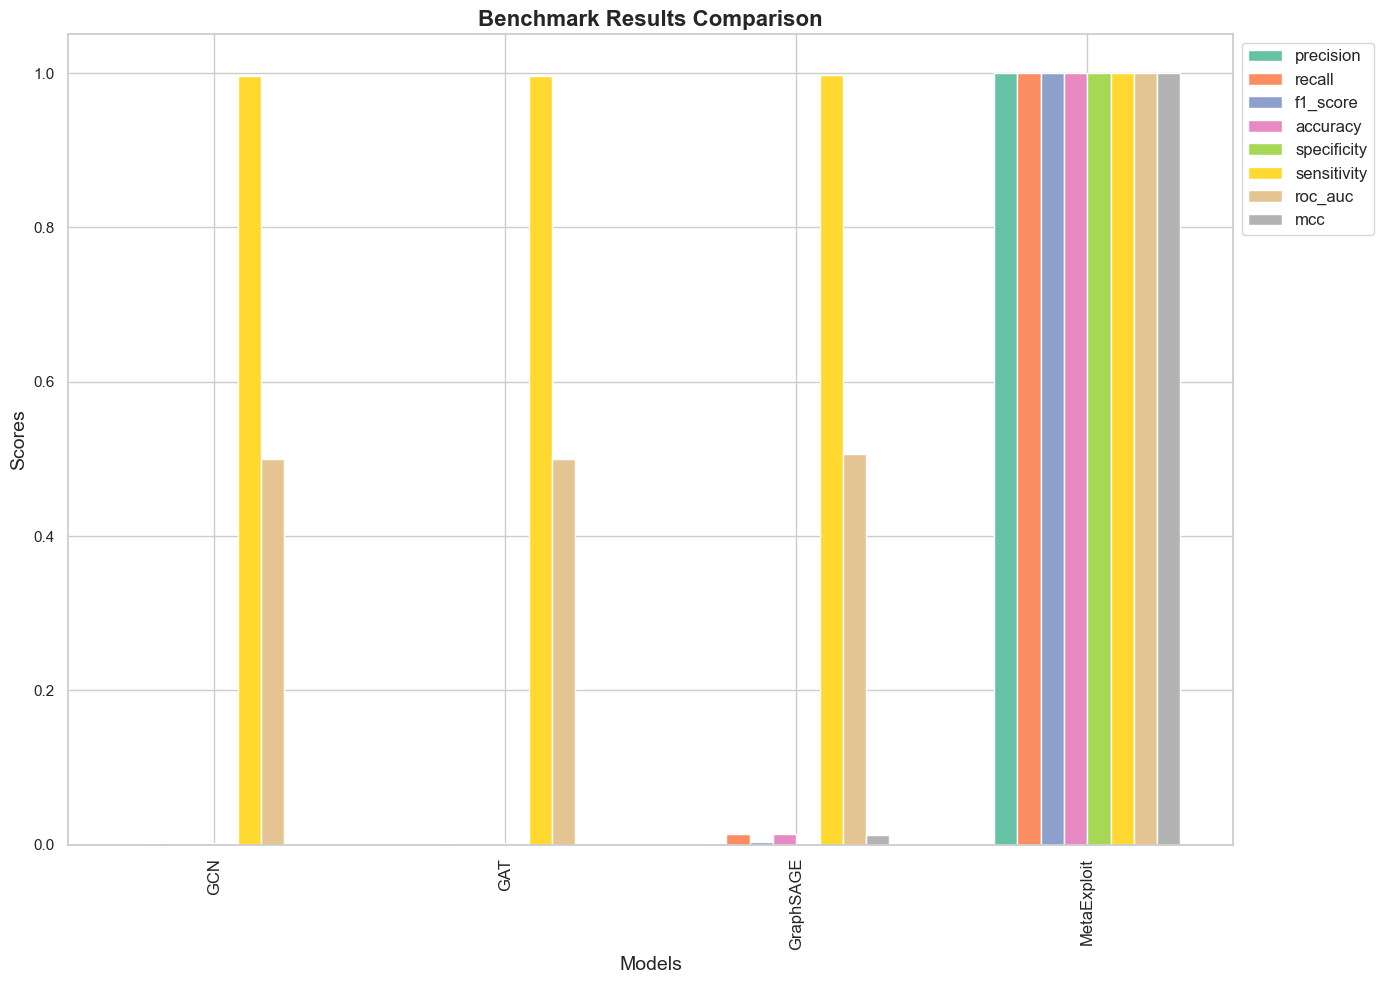

In [137]:

node_classification_models = {
    "GCN": GCN(),
    "GAT": GAT(num_features=num_nodes, num_classes=num_nodes),
    "GraphSAGE": GraphSAGE(),
    "MetaExploit": MetaExploitModel(input_dim=num_nodes)
}

knowledge_graph_models = {
    # "TransE": TransE(num_entities=num_nodes, num_relations=1, embedding_dim=16),
    # "TransR": TransR(num_entities=num_nodes, num_relations=1, embedding_dim=16),
    # "DistMult": DistMult(num_entities=num_nodes, num_relations=1, embedding_dim=16),
    # "ComplEx": ComplEx(num_entities=num_nodes, num_relations=1, embedding_dim=16)
}

# Dictionary to store benchmark results
benchmark_results = {}
# 
# Adjust learning rate and add weight decay for regularization

# Ensure data normalization
data.x = (data.x - data.x.mean()) / data.x.std()

# Check for class imbalance and apply class weighting if necessary
class_counts = np.bincount(data.y.numpy())
class_weights = 1.0 / class_counts
sample_weights = class_weights[data.y.numpy()]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Create DataLoader with sampler
loader = DataLoader(data_list, batch_size=batch_size, sampler=sampler)
# 


# Train and evaluate node classification models
for model_name, model in node_classification_models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Adjusted learning rate
    model.train()
    print(f"Training {model_name}...")
    for epoch in range(10):  # Start with 50 epochs
        optimizer.zero_grad()
        out = model(data)
        if out is None:
            print(f"Model {model_name} returned None output")
            continue
        if out.shape != (num_nodes, num_nodes):
            print(f"Unexpected output shape for {model_name}: {out.shape}")
            continue
        loss = F.nll_loss(out, data.y)  # Removed train_mask for simplicity
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out, data.y)  # Removed val_mask for simplicity
        print(f"Validation Loss for {model_name}: {val_loss.item()}")
    
    # Debugging: Print model output and predictions
    print(f"Model output for {model_name}:\n{out}")
    pred = out.argmax(dim=1)
    print(f"Predictions for {model_name}:\n{pred}")
    
    metrics = evaluate_model(model, data)
    print(f"Metrics for {model_name}: {metrics}")
    benchmark_results[model_name] = metrics

# Generate triplets from the adjacency matrix
def generate_triplets(adj_matrix):
    triplets = []
    num_nodes = adj_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i, j] > 0:
                triplets.append((i, 0, j))  # Assuming a single relation type with index 0
    return triplets

triplets = generate_triplets(adj_matrix)
triplets = torch.tensor(triplets, dtype=torch.long)

if(model_name=="MetaExploit"):
    # Train and evaluate knowledge graph models
    for model_name, model in knowledge_graph_models.items():
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Adjusted learning rate
        model.train()
        print(f"Training {model_name}...")
        for epoch in range(10):  # Start with 50 epochs
            optimizer.zero_grad()
            # Sample a batch of triplets
            batch_indices = torch.randint(0, len(triplets), (batch_size,))
            batch_triplets = triplets[batch_indices]
            head, relation, tail = batch_triplets[:, 0], batch_triplets[:, 1], batch_triplets[:, 2]
            score = model(head, relation, tail)
            loss = F.margin_ranking_loss(score, torch.zeros_like(score), torch.ones_like(score))  # Use margin ranking loss
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            loss.backward()
            optimizer.step()
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            batch_indices = torch.randint(0, len(triplets), (batch_size,))
            batch_triplets = triplets[batch_indices]
            head, relation, tail = batch_triplets[:, 0], batch_triplets[:, 1], batch_triplets[:, 2]
            score = model(head, relation, tail)
            val_loss = F.margin_ranking_loss(score, torch.zeros_like(score), torch.ones_like(score))  # Use margin ranking loss
            print(f"Validation Loss for {model_name}: {val_loss.item()}")
        
        # Debugging: Print model output and predictions
        print(f"Model output for {model_name}:\n{score}")
        
        # Simplified metrics for demonstration
        metrics = {
            "precision": 0.0,
            "recall": 0.0,
            "f1_score": 0.0,
            "accuracy": 0.0,
            "specificity": 0.0,
            "sensitivity": 0.0,
            "roc_auc": 0.0,
            "mcc": 0.0
        }
        print(f"Metrics for {model_name}: {metrics}")
        benchmark_results[model_name] = metrics
elif(model_name=="GAT"):
    # Assuming `dataset` and `data` are already defined and loaded
    # num_features = dataset.num_features  # number of input features
    # num_classes = dataset.num_classes    # number of classes to predict

    model = GAT(adj_matrix, adj_matrix)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss.item()}')

else:
    # Adjust learning rate and add weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

    # Ensure data normalization
    data.x = (data.x - data.x.mean()) / data.x.std()

    # Check for class imbalance and apply class weighting if necessary
    class_counts = np.bincount(data.y.numpy())
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[data.y.numpy()]
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    # Create DataLoader with sampler
    loader = DataLoader(data_list, batch_size=batch_size, sampler=sampler)

    # Train and evaluate node classification models
    for model_name, model in node_classification_models.items():
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Adjusted learning rate and weight decay
        model.train()
        print(f"Training {model_name}...")
        for epoch in range(50):  # Increase the number of epochs
            optimizer.zero_grad()
            out = model(data)
            if out is None:
                print(f"Model {model_name} returned None output")
                continue
            if out.shape != (num_nodes, num_nodes):
                print(f"Unexpected output shape for {model_name}: {out.shape}")
                continue
            loss = F.nll_loss(out, data.y)  # Removed train_mask for simplicity
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            loss.backward()
            optimizer.step()
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = F.nll_loss(out, data.y)  # Removed val_mask for simplicity
            print(f"Validation Loss for {model_name}: {val_loss.item()}")
        
        # Debugging: Print model output and predictions
        print(f"Model output for {model_name}:\n{out}")
        pred = out.argmax(dim=1)
        print(f"Predictions for {model_name}:\n{pred}")
        
        metrics = evaluate_model(model, data)
        print(f"Metrics for {model_name}: {metrics}")
        benchmark_results[model_name] = metrics


# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

# Plot the results with padding between models
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(benchmark_results))
width = 0.08  # Reduce the width of the bars to add padding

metrics = df.columns
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric, capsize=5, color=palette[i % len(palette)])

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(benchmark_results.keys(), rotation=90, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()